In [2]:
from vllm import LLM

llm = LLM(
    model="Qwen/Qwen3-VL-Embedding-2B",
    runner="pooling",
    max_model_len=2256,
    quantization="mxfp4",
    gpu_memory_utilization=0.4
)

INFO 01-24 22:55:10 [utils.py:263] non-default args: {'runner': 'pooling', 'max_model_len': 2256, 'gpu_memory_utilization': 0.4, 'disable_log_stats': True, 'quantization': 'mxfp4', 'model': 'Qwen/Qwen3-VL-Embedding-2B'}
INFO 01-24 22:55:13 [model.py:859] Resolved `--convert auto` to `--convert embed`. Pass the value explicitly to silence this message.
INFO 01-24 22:55:13 [model.py:530] Resolved architecture: Qwen3VLForConditionalGeneration
INFO 01-24 22:55:13 [model.py:1545] Using max model len 2256
INFO 01-24 22:55:13 [scheduler.py:229] Chunked prefill is enabled with max_num_batched_tokens=8192.
(EngineCore_DP0 pid=130557) INFO 01-24 22:55:16 [core.py:97] Initializing a V1 LLM engine (v0.14.0) with config: model='Qwen/Qwen3-VL-Embedding-2B', speculative_config=None, tokenizer='Qwen/Qwen3-VL-Embedding-2B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=2256, download_dir=None, load_form

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


(EngineCore_DP0 pid=130557) INFO 01-24 22:55:31 [default_loader.py:291] Loading weights took 1.21 seconds
(EngineCore_DP0 pid=130557) INFO 01-24 22:55:31 [gpu_model_runner.py:3905] Model loading took 4.31 GiB memory and 2.800450 seconds
(EngineCore_DP0 pid=130557) INFO 01-24 22:55:32 [gpu_model_runner.py:4715] Encoder cache will be initialized with a budget of 8192 tokens, and profiled with 6 image items of the maximum feature size.
(EngineCore_DP0 pid=130557) INFO 01-24 22:55:40 [backends.py:644] Using cache directory: /home/administrator/.cache/vllm/torch_compile_cache/c389ac29ce/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=130557) INFO 01-24 22:55:40 [backends.py:704] Dynamo bytecode transform time: 7.55 s
(EngineCore_DP0 pid=130557) INFO 01-24 22:55:46 [backends.py:226] Directly load the compiled graph(s) for compile range (1, 8192) from the cache, took 1.186 s
(EngineCore_DP0 pid=130557) INFO 01-24 22:55:46 [monitor.py:34] torch.compile takes 8.73 s in total
(Eng

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 51/51 [00:01<00:00, 25.73it/s]


(EngineCore_DP0 pid=130557) INFO 01-24 22:55:50 [gpu_model_runner.py:4856] Graph capturing finished in 3 secs, took 0.33 GiB
(EngineCore_DP0 pid=130557) INFO 01-24 22:55:50 [core.py:273] init engine (profile, create kv cache, warmup model) took 18.52 seconds
INFO 01-24 22:55:50 [llm.py:347] Supported tasks: ['embed', 'token_embed']


In [19]:
from sqlalchemy import text, create_engine
from PIL import Image
from e_commerce_recommendation.configs.settings import Settings

def build_prompt(image, title):
    return [
        {
            "role": "system",
            "content": "You are a multimodal embedding model. Focus primarily on encoding the VISUAL appearance (colors, style, patterns, design, and amazon ecommerce attributes) of the product shown in the image. The title provides supplementary context."
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": f"Product: {title}"}
            ]
        }
    ]


def embed_product(image: Image.Image, title: str, llm: LLM):
    conversation = build_prompt(image, title)

    vllm_input = llm.llm_engine.tokenizer.apply_chat_template(
        conversation,
        tokenize=False,
        add_generation_prompt=True
    )

    out = llm.embed([vllm_input], use_tqdm=False)[0]
    return out.outputs.embedding

def retrieve_similar_products(query_embedding, product_embeddings, top_k=5):
    pass 

settings = Settings()
DATABASE_URL = settings.SAMPLE_DATABASE_URL
engine = create_engine(
    DATABASE_URL,
    echo=False,
)

# with engine.connect() as conn:
#     result = conn.execute(
#         text("SELECT id, title, image_path, embedding FROM products")
#     )
#     products = result.fetchall()

query_image = Image.open("/home/administrator/Downloads/allen.jpg")
query_title = "allen solly t shirt"
query_embedding = embed_product(query_image, query_title, llm)
query_embedding.__len__()

2048

In [20]:
from sqlalchemy import text

query = text("""
SELECT
    id,
    title,
    image_path,
    embedding
FROM products
ORDER BY embedding <=> :query_embedding
LIMIT 50
""")

with engine.connect() as conn:
    result = conn.execute(
        query,
        {"query_embedding": str(query_embedding)}   # IMPORTANT
    )
    products = result.fetchall()

products

[(15134, 'Men T-Shirt', '/home/administrator/Desktop/datascience/github/e-commerce-recommendation/data/raw_data/india/images/B07TFRM839.jpg', '[0.006405,-0.017395,0.00242,0.020088,0.07686,-0.045999,-0.078024,0.00575,0.042797,0.021544,0.010918,0.000507,-0.024747,-0.002056,0.055316,-0.057936,0 ... (18879 characters truncated) ... -0.02169,0.003002,0.063759,-0.017323,-0.003803,-0.024892,0.0115,-0.012883,-0.014411,-0.034791,0.029114,3.6e-05,-0.006041,-0.031006,0.02824,-0.003439]'),
 (1063, 'Men T-Shirt', '/home/administrator/Desktop/datascience/github/e-commerce-recommendation/data/raw_data/india/images/B0CJJNQ6QY.jpg', '[0.00735,-0.017321,0.002656,0.019941,0.076269,-0.045703,-0.077433,0.005931,0.043374,0.021833,0.011207,0.000562,-0.024598,-0.002265,0.055892,-0.058512 ... (18898 characters truncated) ... 1396,0.002729,0.06346,-0.016884,-0.003639,-0.024162,0.012008,-0.012008,-0.013391,-0.034787,0.029401,-0.000619,-0.007023,-0.030857,0.028674,-0.003912]'),
 (1648, 'I Am Kenough Shirt T-Shirt

In [21]:
test_image = Image.open("/home/administrator/Desktop/datascience/github/e-commerce-recommendation/data/raw_data/usa/images/B00IKIEKS2.jpg")
test_title = ""
test_embedding = embed_product(test_image, test_title, llm)

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
similarities = []
for product in products:
    product_embedding = np.fromstring(product[3][1:-1], sep=',')
    similarity = cosine_similarity(
        [query_embedding],
        [product_embedding]
    )[0][0]
    similarities.append((product[1], similarity))

similarities

[('Men T-Shirt', np.float64(0.6783076763601774)),
 ('Men T-Shirt', np.float64(0.67609666474374)),
 ('I Am Kenough Shirt T-Shirt', np.float64(0.6551448088920077)),
 ('100% Cotton T-Shirt', np.float64(0.6360215948359171)),
 ('YALI Slim T-Shirt', np.float64(0.6130317728278951)),
 ("Scott Men's T-Shirts", np.float64(0.6118471093483893)),
 ('पुरुषों टी-शर्ट', np.float64(0.5982929209709651)),
 ('पुरुषों टी-शर्ट', np.float64(0.5981366536008188)),
 ('पुरुषों टी-शर्ट', np.float64(0.5981080063923769)),
 ('पुरुषों टी-शर्ट', np.float64(0.5980573490456371)),
 ('BGFIIPAJG Men Dress Shirt Slim Fit Top Shirt O Neck Special Printed Short Sleeve Loose T-Shirt Fashion Comfort Top Blouses Dresses Shirt Football Shirts Mens Vest Tops for Men Printed t Shirts',
  np.float64(0.5938252481306308)),
 ("Girls' T-Shirt", np.float64(0.5933175724883264)),
 ('DTF Print, Full Color DTF T-Shirt Heat Transfer, Personalized Color DTF, Press Ready, Custom Transfer, Ready to Apply, Your Custom Design',
  np.float64(0.5908

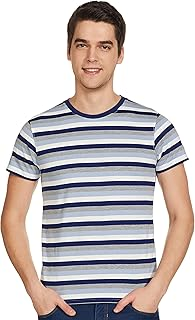

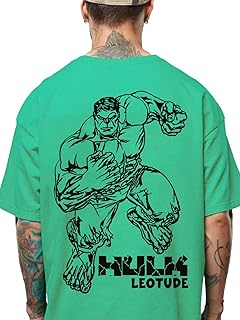

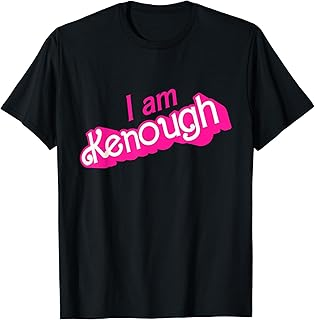

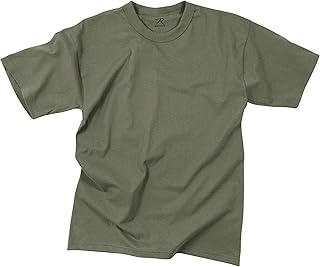

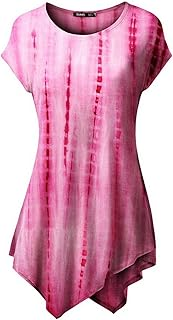

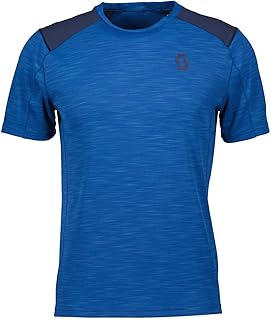

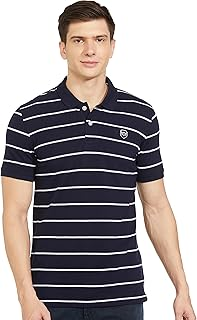

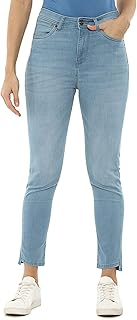

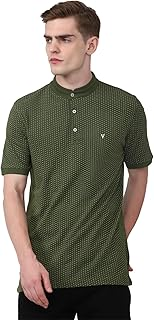

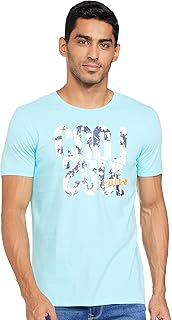

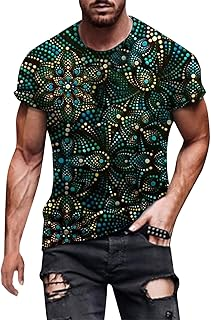

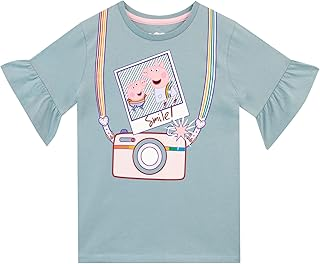

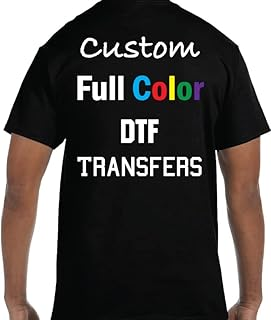

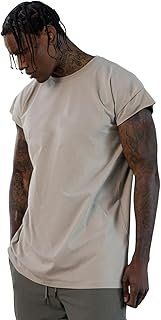

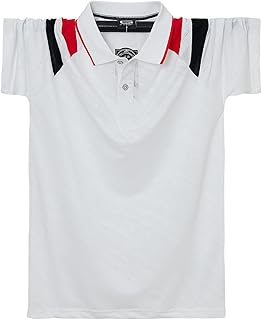

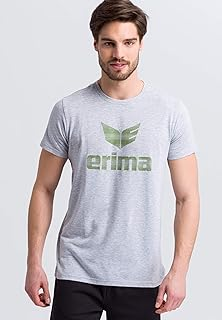

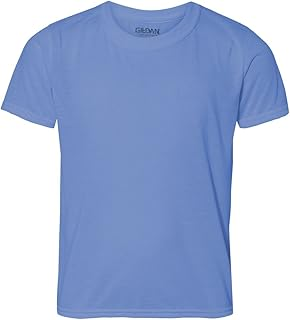

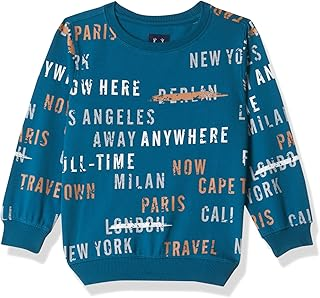

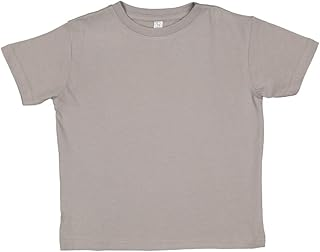

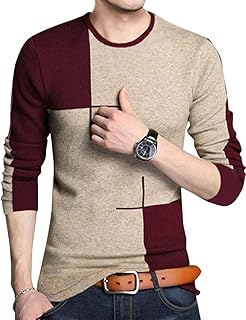

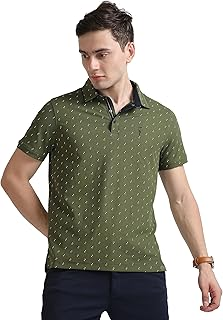

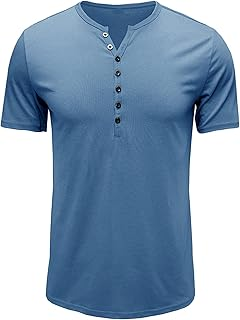

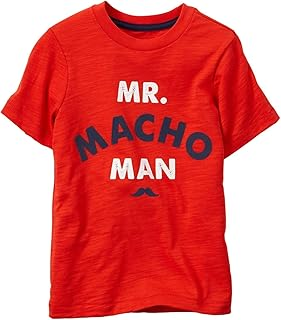

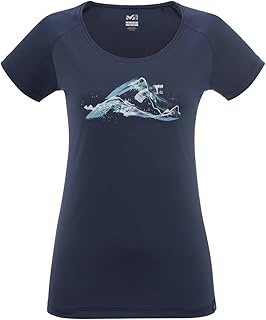

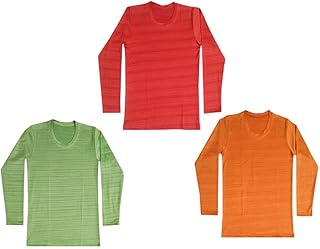

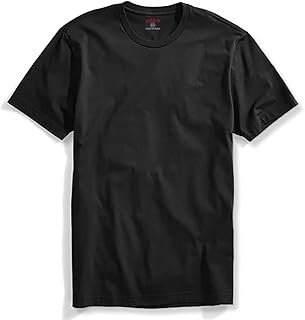

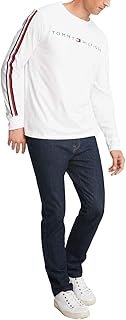

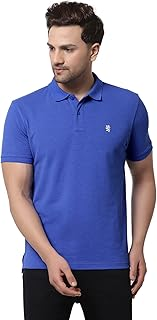

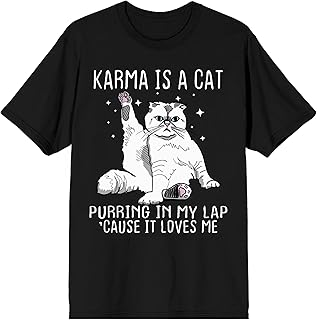

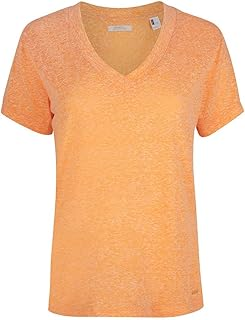

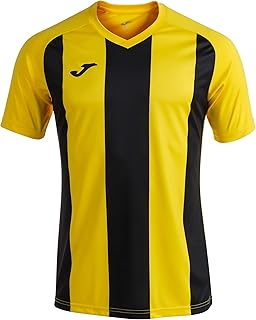

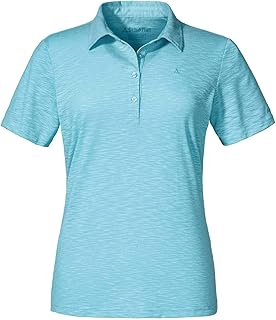

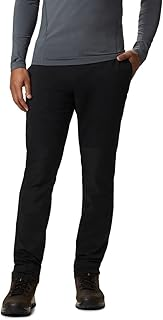

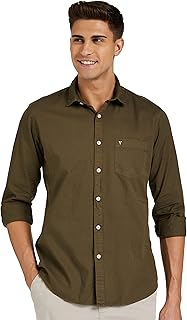

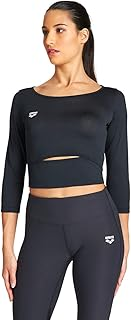

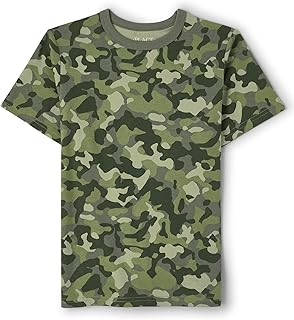

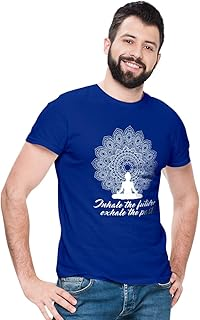

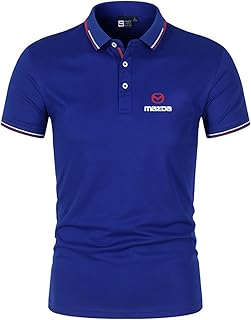

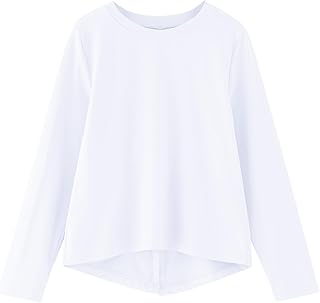

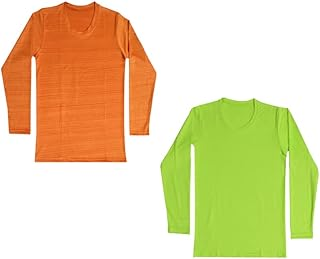

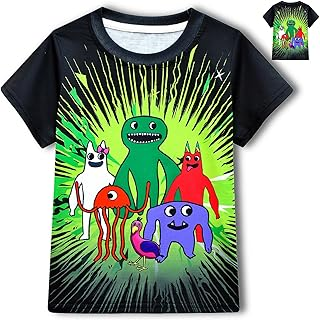

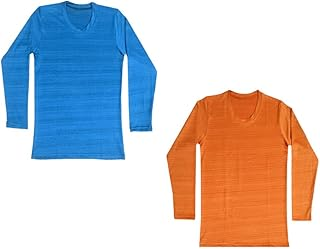

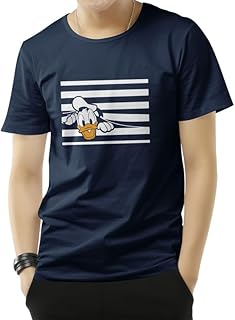

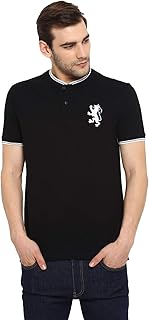

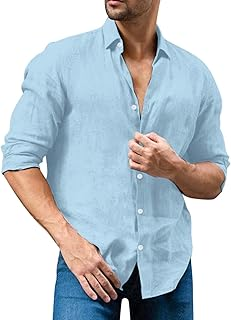

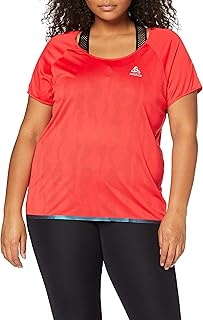

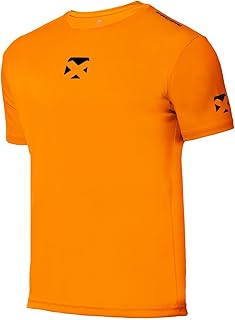

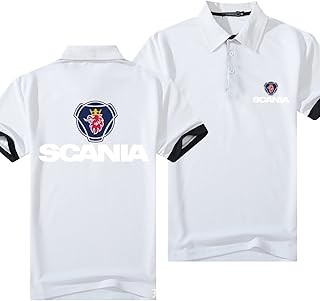

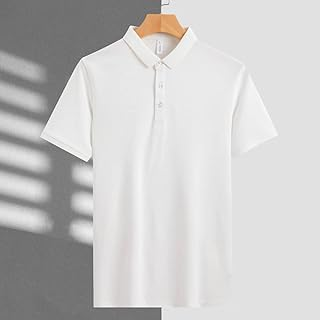

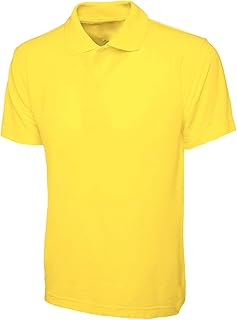

In [22]:
for product in products:
    image =Image.open(product[2])  
    display(image)

# Reranking with Vision Model

Load a reranker model to refine the top 50 results from vector search

In [1]:
# Load proper Qwen3-VL-Reranker-2B with correct configuration
from vllm import LLM, EngineArgs

print("Loading Qwen3-VL-Reranker-2B...")

engine_args = EngineArgs(
    model="Qwen/Qwen3-VL-Reranker-2B",
    runner="pooling",
    dtype="bfloat16",
    trust_remote_code=True,
    gpu_memory_utilization=0.25,
    hf_overrides={
        "architectures": ["Qwen3VLForSequenceClassification"],
        "classifier_from_token": ["no", "yes"],
        "is_original_qwen3_reranker": True,
    },
    max_model_len=2256,
)

reranker_llm = LLM(**vars(engine_args))
print("✓ Reranker loaded")

Loading Qwen3-VL-Reranker-2B...
INFO 01-24 22:54:26 [utils.py:263] non-default args: {'runner': 'pooling', 'trust_remote_code': True, 'dtype': 'bfloat16', 'max_model_len': 2256, 'gpu_memory_utilization': 0.25, 'hf_overrides': {'architectures': ['Qwen3VLForSequenceClassification'], 'classifier_from_token': ['no', 'yes'], 'is_original_qwen3_reranker': True}, 'model': 'Qwen/Qwen3-VL-Reranker-2B'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 01-24 22:54:27 [model.py:859] Resolved `--convert auto` to `--convert classify`. Pass the value explicitly to silence this message.
INFO 01-24 22:54:27 [model.py:530] Resolved architecture: Qwen3VLForSequenceClassification
INFO 01-24 22:54:27 [model.py:1545] Using max model len 2256
INFO 01-24 22:54:27 [scheduler.py:229] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 01-24 22:54:27 [vllm.py:630] Asynchronous scheduling is enabled.
INFO 01-24 22:54:27 [vllm.py:637] Disabling NCCL for DP synchronization when using async scheduling.
WARNING 01-24 22:54:27 [vllm.py:744] Pooling models do not support full cudagraphs. Overriding cudagraph_mode to PIECEWISE.
(EngineCore_DP0 pid=129699) INFO 01-24 22:54:32 [core.py:97] Initializing a V1 LLM engine (v0.14.0) with config: model='Qwen/Qwen3-VL-Reranker-2B', speculative_config=None, tokenizer='Qwen/Qwen3-VL-Reranker-2B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_cod

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


(EngineCore_DP0 pid=129699) INFO 01-24 22:54:49 [default_loader.py:291] Loading weights took 3.26 seconds
(EngineCore_DP0 pid=129699) INFO 01-24 22:54:49 [gpu_model_runner.py:3905] Model loading took 4.31 GiB memory and 4.582939 seconds
(EngineCore_DP0 pid=129699) INFO 01-24 22:54:50 [gpu_model_runner.py:4715] Encoder cache will be initialized with a budget of 8192 tokens, and profiled with 6 image items of the maximum feature size.
(EngineCore_DP0 pid=129699) INFO 01-24 22:54:58 [backends.py:644] Using cache directory: /home/administrator/.cache/vllm/torch_compile_cache/15cee5b1bb/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=129699) INFO 01-24 22:54:58 [backends.py:704] Dynamo bytecode transform time: 7.85 s
(EngineCore_DP0 pid=129699) INFO 01-24 22:55:03 [backends.py:261] Cache the graph of compile range (1, 8192) for later use
(EngineCore_DP0 pid=129699) INFO 01-24 22:55:05 [backends.py:278] Compiling a graph for compile range (1, 8192) takes 2.48 s
(EngineCore_DP0

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 51/51 [00:01<00:00, 26.32it/s]


(EngineCore_DP0 pid=129699) INFO 01-24 22:55:09 [gpu_model_runner.py:4856] Graph capturing finished in 3 secs, took 0.31 GiB
(EngineCore_DP0 pid=129699) INFO 01-24 22:55:10 [core.py:273] init engine (profile, create kv cache, warmup model) took 20.20 seconds
INFO 01-24 22:55:10 [llm.py:347] Supported tasks: ['classify', 'score', 'token_classify']
✓ Reranker loaded


In [23]:
import os
from vllm.entrypoints.score_utils import ScoreMultiModalParam

def format_image_to_score_param(image):
    """Format PIL Image to ScoreMultiModalParam for reranker."""
    # Save image temporarily to get file path
    temp_path = "/tmp/temp_rerank_image.jpg"
    image.save(temp_path)
    
    image_url = 'file://' + os.path.abspath(temp_path)
    
    content = [{
        "type": "image_url",
        "image_url": {
            "url": image_url
        }
    }]
    
    return {"content": content}

def compute_rerank_score(query_img, product_img, reranker_llm: LLM):
    """
    Use Qwen3-VL-Reranker to score visual similarity.
    Returns a similarity score (higher = more similar).
    """
    # Prepare query (empty text for image-only)
    query_text = ""
    
    # Format document (product image)
    doc_param = format_image_to_score_param(product_img)
    
    # Save query image temporarily
    query_temp_path = "/tmp/temp_query_image.jpg"
    query_img.save(query_temp_path)
    
    # Create query param with both images
    query_param = {
        "content": [
            {
                "type": "image_url",
                "image_url": {
                    "url": 'file://' + os.path.abspath(query_temp_path)
                }
            },
            {
                "type": "image_url", 
                "image_url": {
                    "url": doc_param["content"][0]["image_url"]["url"]
                }
            }
        ]
    }
    
    # Get score
    outputs = reranker_llm.score("", query_param, chat_template=None)
    score = outputs[0].outputs.score
    
    return float(score)

print("✓ Reranking function defined")

✓ Reranking function defined


In [24]:
# Rerank the top 50 results using Qwen3-VL-Reranker with proper API
from tqdm import tqdm

print(f"Reranking top 50 products with Qwen3-VL-Reranker-2B...")
reranked_results = []

# Process each product
for idx, product in enumerate(tqdm(products[:50])):
    try:
        product_img = Image.open(product[2]).convert("RGB")
        
        # Get reranking score
        score = compute_rerank_score(query_image, product_img, reranker_llm)
        
        reranked_results.append({
            'id': product[0],
            'title': product[1],
            'image_path': product[2],
            'vector_rank': idx + 1,
            'rerank_score': score
        })
    except Exception as e:
        print(f"\nError processing product {product[0]}: {e}")
        # Add with default score to not skip
        reranked_results.append({
            'id': product[0],
            'title': product[1],
            'image_path': product[2],
            'vector_rank': idx + 1,
            'rerank_score': 0.0
        })

# Sort by rerank score (descending)
reranked_results.sort(key=lambda x: x['rerank_score'], reverse=True)

print(f"\n✓ Reranking complete! Processed {len(reranked_results)} products.")

Reranking top 50 products with Qwen3-VL-Reranker-2B...


100%|██████████| 50/50 [00:00<00:00, 302.55it/s]


Error processing product 15134: Only one multi-modal item is supported

Error processing product 1063: Only one multi-modal item is supported

Error processing product 1648: Only one multi-modal item is supported

Error processing product 11330: Only one multi-modal item is supported

Error processing product 18863: Only one multi-modal item is supported

Error processing product 20527: Only one multi-modal item is supported

Error processing product 6282: Only one multi-modal item is supported

Error processing product 5390: Only one multi-modal item is supported

Error processing product 6710: Only one multi-modal item is supported

Error processing product 12117: Only one multi-modal item is supported

Error processing product 19465: Only one multi-modal item is supported

Error processing product 5284: Only one multi-modal item is supported

Error processing product 5594: Only one multi-modal item is supported

Error processing product 20719: Only one multi-modal item is supported

In [25]:
# Compare: Vector Search vs Reranked Results
print("=" * 80)
print("COMPARISON: Vector Search (Top 10) vs Reranked (Top 10)")
print("=" * 80)

print("\n📊 VECTOR SEARCH TOP 10:")
for i, product in enumerate(products[:10]):
    print(f"{i+1}. [Rank {i+1}] {product[1][:70]}")

print("\n" + "="*80)
print("\n🔥 RERANKED TOP 10:")
for i, item in enumerate(reranked_results[:10]):
    print(f"{i+1}. [Was Rank {item['vector_rank']}] Score: {item['rerank_score']:.3f} - {item['title'][:60]}")

print("\n" + "="*80)

COMPARISON: Vector Search (Top 10) vs Reranked (Top 10)

📊 VECTOR SEARCH TOP 10:
1. [Rank 1] Men T-Shirt
2. [Rank 2] Men T-Shirt
3. [Rank 3] I Am Kenough Shirt T-Shirt
4. [Rank 4] 100% Cotton T-Shirt
5. [Rank 5] YALI Slim T-Shirt
6. [Rank 6] Scott Men's T-Shirts
7. [Rank 7] पुरुषों टी-शर्ट
8. [Rank 8] पुरुषों टी-शर्ट
9. [Rank 9] पुरुषों टी-शर्ट
10. [Rank 10] पुरुषों टी-शर्ट


🔥 RERANKED TOP 10:
1. [Was Rank 1] Score: 0.000 - Men T-Shirt
2. [Was Rank 2] Score: 0.000 - Men T-Shirt
3. [Was Rank 3] Score: 0.000 - I Am Kenough Shirt T-Shirt
4. [Was Rank 4] Score: 0.000 - 100% Cotton T-Shirt
5. [Was Rank 5] Score: 0.000 - YALI Slim T-Shirt
6. [Was Rank 6] Score: 0.000 - Scott Men's T-Shirts
7. [Was Rank 7] Score: 0.000 - पुरुषों टी-शर्ट
8. [Was Rank 8] Score: 0.000 - पुरुषों टी-शर्ट
9. [Was Rank 9] Score: 0.000 - पुरुषों टी-शर्ट
10. [Was Rank 10] Score: 0.000 - पुरुषों टी-शर्ट



🖼️  QUERY IMAGE:


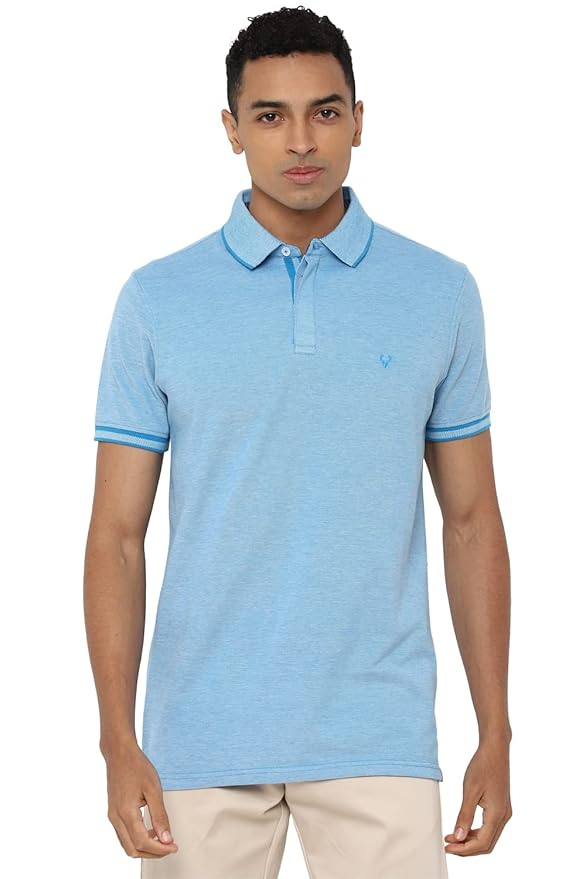


TOP 5 RERANKED RESULTS (by visual similarity score):

1. Rerank Score: 0.000 | Vector Rank: #1
   Men T-Shirt


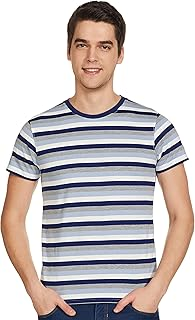


2. Rerank Score: 0.000 | Vector Rank: #2
   Men T-Shirt


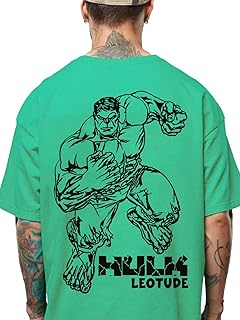


3. Rerank Score: 0.000 | Vector Rank: #3
   I Am Kenough Shirt T-Shirt


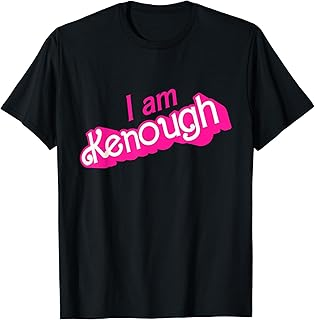


4. Rerank Score: 0.000 | Vector Rank: #4
   100% Cotton T-Shirt


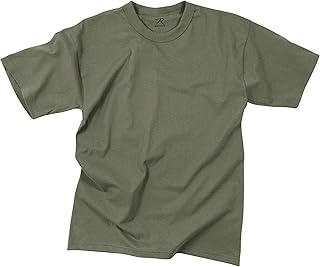


5. Rerank Score: 0.000 | Vector Rank: #5
   YALI Slim T-Shirt


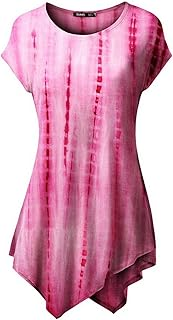

In [26]:
# Visual comparison - show query and top 5 reranked results
print("🖼️  QUERY IMAGE:")
display(query_image)

print("\n" + "="*80)
print("TOP 5 RERANKED RESULTS (by visual similarity score):")
print("="*80)

for i, item in enumerate(reranked_results[:5]):
    print(f"\n{i+1}. Rerank Score: {item['rerank_score']:.3f} | Vector Rank: #{item['vector_rank']}")
    print(f"   {item['title'][:80]}")
    img = Image.open(item['image_path'])
    display(img)